## Traditional machine learning
Feature(s): 'SMILES' column

- Copolymer sequence of A and B monomer
- Binary encoding

Target: y_bin

- Binary class

In [19]:
import sys
import os
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from loguru import logger

logger.remove()
logger.add(sys.stderr, level="WARNING")
# Append the parent directory of your package to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..')))

In [20]:
import pandas as pd
import numpy as np
import zipfile

path_to_dataset = 'train_polymers.csv'
csv_filename = 'train_polymers.csv'

# Open the file, Correct the encoding and sep if necessary
if path_to_dataset.endswith('.zip'):
    with zipfile.ZipFile(path_to_dataset, 'r') as z:
        # Open the CSV file within the ZIP file
        with z.open(csv_filename) as f:
            # Read the CSV file into a DataFrame
            df = pd.read_csv(f, sep=',', on_bad_lines='warn', index_col = 0)
else:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(path_to_dataset, sep=',', on_bad_lines='warn', index_col = 0)


print('Count of unique smiles:', df.SMILES.unique().shape[0])
print('Count of all of the smiles:', df.shape[0])


Count of unique smiles: 16000
Count of all of the smiles: 16000


In [21]:
# Define mapping
mapping = {'A': 0, 'B': 1}

# Apply mapping and convert sequences to arrays
def encode_sequence(sequence):
    return np.array([mapping[char] for char in sequence.split()])

df['Encoded'] = df['SMILES'].apply(encode_sequence)

In [22]:
display(df.head(5))

,SMILES,y,y_bin,Encoded
0,B B B B A A B B B A B A B B B A B B B B,7.759848,0,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, ..."
1,B B B A A A B B A A B A B A B B B A B B,8.133042,0,"[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, ..."
2,A A B B A B B A B A B B B B A B B B B B,7.717979,0,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, ..."
3,B B B A B A A A A B A B A B A B B B B B,8.147355,0,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, ..."
4,B B B B B B A B B A B B B B B B B B B A,7.603120,0,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."


In [23]:
from MLPipeline import MLmodel, BinTheTarget

Target = ['y_bin']
Features = ['Encoded']
Feature_types = ['numerical']
input = df

In [24]:
def objectiveRandomForestClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


def objectiveXGBClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize for XGBClassifier.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),  # L2 regularization
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


In [25]:
MODEL_NAMES = ['RandomForestClassifier', 'XGBClassifier']
TARGETS = [[i] for i in Target ]
TRAIN_SIZES = [25, 50, 100, 200]

result = []
for seed in [1, 2, 3]:
    for model_name in MODEL_NAMES:
        for target in TARGETS:
            for train_size in TRAIN_SIZES:
                print(f'RUN: Model:{model_name} / Target:{target} / Train size:{train_size} / Seed:{seed}')
                
                if model_name == 'RandomForestClassifier':
                    objective = objectiveRandomForestClassifier
                elif model_name == 'XGBClassifier':
                    objective = objectiveXGBClassifier

                model = MLmodel(modelType=model_name, 
                df=input,
                randomSeed=seed,
                train_count = train_size,
                test_count = 50, 
                target=target, 
                features=Features, 
                hyperparameter_tuning=True,
                feature_types=Feature_types,
                optimization_method='optuna', 
                optimization_trials=2,
                objective=lambda trial: objective(trial, model)
                )

                model.train()
                eval, summary = model.evaluate()
                result.append({**summary, **eval, 'seed':seed})



[I 2024-09-17 16:11:27,312] A new study created in memory with name: no-name-d2824db1-9dea-4756-b640-8b69d210eb58


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:25 / Seed:1


[I 2024-09-17 16:11:28,240] Trial 0 finished with value: 0.8 and parameters: {'n_estimators': 242, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8.
[I 2024-09-17 16:11:29,676] Trial 1 finished with value: 0.5599999999999999 and parameters: {'n_estimators': 254, 'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8.
[I 2024-09-17 16:11:29,876] A new study created in memory with name: no-name-070bc1a6-5ea9-4f68-bdba-18010860db5d


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:50 / Seed:1


[I 2024-09-17 16:11:30,426] Trial 0 finished with value: 0.82 and parameters: {'n_estimators': 138, 'max_depth': 40, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.82.
[I 2024-09-17 16:11:31,137] Trial 1 finished with value: 0.82 and parameters: {'n_estimators': 186, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.82.
[I 2024-09-17 16:11:31,255] A new study created in memory with name: no-name-790677c2-8cde-44c6-8770-b2f0d1ec6f89


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:100 / Seed:1


[I 2024-09-17 16:11:32,848] Trial 0 finished with value: 0.8099999999999999 and parameters: {'n_estimators': 296, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8099999999999999.
[I 2024-09-17 16:11:33,621] Trial 1 finished with value: 0.7499999999999999 and parameters: {'n_estimators': 197, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8099999999999999.
[I 2024-09-17 16:11:33,955] A new study created in memory with name: no-name-1b5c43bd-fd09-490e-a4c1-01f965e2d4c4


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:200 / Seed:1


[I 2024-09-17 16:11:34,695] Trial 0 finished with value: 0.8099999999999999 and parameters: {'n_estimators': 130, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8099999999999999.
[I 2024-09-17 16:11:35,019] Trial 1 finished with value: 0.8149999999999998 and parameters: {'n_estimators': 77, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8149999999999998.
[I 2024-09-17 16:11:35,100] A new study created in memory with name: no-name-b3f0bd05-deca-4f05-822e-44dcf564f4ab


RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:25 / Seed:1


[I 2024-09-17 16:11:35,323] Trial 0 finished with value: 0.72 and parameters: {'n_estimators': 153, 'max_depth': 11, 'learning_rate': 0.029154084794243612, 'subsample': 0.8226502587106548, 'colsample_bytree': 0.7482731791901271, 'gamma': 4.296383689797619e-05, 'reg_alpha': 3.5952433766639435e-06, 'reg_lambda': 8.018468442392555e-07}. Best is trial 0 with value: 0.72.
[I 2024-09-17 16:11:35,538] Trial 1 finished with value: 0.8 and parameters: {'n_estimators': 173, 'max_depth': 9, 'learning_rate': 0.1712454192937208, 'subsample': 0.5300913636588169, 'colsample_bytree': 0.5692716363328156, 'gamma': 0.6498224014213072, 'reg_alpha': 0.0008838994436860332, 'reg_lambda': 0.9257465819315338}. Best is trial 1 with value: 0.8.
[I 2024-09-17 16:11:35,591] A new study created in memory with name: no-name-a977fe7f-8ed3-4787-8d9e-638b457c6b5f
[I 2024-09-17 16:11:35,778] Trial 0 finished with value: 0.74 and parameters: {'n_estimators': 113, 'max_depth': 13, 'learning_rate': 0.25487580637108864, 'su

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:50 / Seed:1


[I 2024-09-17 16:11:36,119] Trial 1 finished with value: 0.82 and parameters: {'n_estimators': 277, 'max_depth': 8, 'learning_rate': 0.05838062208997298, 'subsample': 0.9993555799814957, 'colsample_bytree': 0.5010413495491599, 'gamma': 0.7531622586638019, 'reg_alpha': 1.1494282185495956e-08, 'reg_lambda': 0.00023290504862059862}. Best is trial 1 with value: 0.82.
[I 2024-09-17 16:11:36,224] A new study created in memory with name: no-name-786e8b32-ea3a-46a0-bd45-f5d3f203b1af


RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:100 / Seed:1


[I 2024-09-17 16:11:36,499] Trial 0 finished with value: 0.7300000000000001 and parameters: {'n_estimators': 174, 'max_depth': 7, 'learning_rate': 0.15983492613584438, 'subsample': 0.7374737216015083, 'colsample_bytree': 0.7471087337737901, 'gamma': 5.677353213812092e-07, 'reg_alpha': 0.22116955307336203, 'reg_lambda': 1.1021935211047258e-06}. Best is trial 0 with value: 0.7300000000000001.
[I 2024-09-17 16:11:36,740] Trial 1 finished with value: 0.78 and parameters: {'n_estimators': 117, 'max_depth': 11, 'learning_rate': 0.014604795963241744, 'subsample': 0.7677518923965617, 'colsample_bytree': 0.9637980464716349, 'gamma': 0.0729576629353412, 'reg_alpha': 0.0040178339241397475, 'reg_lambda': 7.845013488704975e-08}. Best is trial 1 with value: 0.78.
[I 2024-09-17 16:11:36,805] A new study created in memory with name: no-name-3ce0cd75-75b5-4c2f-aef4-9244803f03ac


RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:200 / Seed:1


[I 2024-09-17 16:11:37,146] Trial 0 finished with value: 0.8 and parameters: {'n_estimators': 193, 'max_depth': 8, 'learning_rate': 0.11597175217563821, 'subsample': 0.5008705357987258, 'colsample_bytree': 0.6404452882576476, 'gamma': 4.1812018197301724e-05, 'reg_alpha': 0.005545086116118561, 'reg_lambda': 6.193232087431526e-06}. Best is trial 0 with value: 0.8.
[I 2024-09-17 16:11:37,717] Trial 1 finished with value: 0.7849999999999999 and parameters: {'n_estimators': 269, 'max_depth': 12, 'learning_rate': 0.01458836574374024, 'subsample': 0.9335280764776983, 'colsample_bytree': 0.7250214768825678, 'gamma': 2.094636999033389e-06, 'reg_alpha': 0.009866837976335124, 'reg_lambda': 0.024316285885421684}. Best is trial 0 with value: 0.8.
[I 2024-09-17 16:11:37,807] A new study created in memory with name: no-name-d0227c78-6988-4db0-8172-f6117017ef0a


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:25 / Seed:2


[I 2024-09-17 16:11:38,890] Trial 0 finished with value: 0.68 and parameters: {'n_estimators': 297, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.68.
[I 2024-09-17 16:11:39,547] Trial 1 finished with value: 0.64 and parameters: {'n_estimators': 172, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.68.
[I 2024-09-17 16:11:39,775] A new study created in memory with name: no-name-bb09cd26-2b4b-4bc1-b4a3-50bf344135c2


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:50 / Seed:2


[I 2024-09-17 16:11:40,545] Trial 0 finished with value: 0.74 and parameters: {'n_estimators': 141, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.74.
[I 2024-09-17 16:11:41,543] Trial 1 finished with value: 0.72 and parameters: {'n_estimators': 184, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.74.
[I 2024-09-17 16:11:41,725] A new study created in memory with name: no-name-af797df5-6e13-4e30-a8b3-734283fd561c


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:100 / Seed:2


[I 2024-09-17 16:11:42,198] Trial 0 finished with value: 0.7799999999999999 and parameters: {'n_estimators': 110, 'max_depth': 40, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.7799999999999999.
[I 2024-09-17 16:11:43,070] Trial 1 finished with value: 0.7799999999999999 and parameters: {'n_estimators': 224, 'max_depth': None, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.7799999999999999.
[I 2024-09-17 16:11:43,178] A new study created in memory with name: no-name-8808c3ab-4ded-4d30-ba20-4d1d4c12bbb1


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:200 / Seed:2


[I 2024-09-17 16:11:43,972] Trial 0 finished with value: 0.775 and parameters: {'n_estimators': 185, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.775.
[I 2024-09-17 16:11:45,030] Trial 1 finished with value: 0.76 and parameters: {'n_estimators': 238, 'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.775.
[I 2024-09-17 16:11:45,218] A new study created in memory with name: no-name-b49895e5-6cd2-49c2-ae2a-442972efbac0


RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:25 / Seed:2


[I 2024-09-17 16:11:45,519] Trial 0 finished with value: 0.64 and parameters: {'n_estimators': 205, 'max_depth': 5, 'learning_rate': 0.031168707942966032, 'subsample': 0.9097790243365886, 'colsample_bytree': 0.9173551450427959, 'gamma': 0.0006971400616796171, 'reg_alpha': 0.34012166596758964, 'reg_lambda': 2.3397561536701336e-06}. Best is trial 0 with value: 0.64.
[I 2024-09-17 16:11:45,668] Trial 1 finished with value: 0.64 and parameters: {'n_estimators': 96, 'max_depth': 10, 'learning_rate': 0.23825199514155465, 'subsample': 0.6149280762950902, 'colsample_bytree': 0.6821292737067379, 'gamma': 2.6210620610839926e-07, 'reg_alpha': 0.019149395977718836, 'reg_lambda': 0.26531250149295293}. Best is trial 0 with value: 0.64.
[I 2024-09-17 16:11:45,734] A new study created in memory with name: no-name-5fe33916-f1b3-4e77-9465-fb75c6bb5ae6


RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:50 / Seed:2


[I 2024-09-17 16:11:46,079] Trial 0 finished with value: 0.74 and parameters: {'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.012393141400806256, 'subsample': 0.5055049810323409, 'colsample_bytree': 0.9152368893017945, 'gamma': 4.44531179793151e-07, 'reg_alpha': 4.1611493924783253e-07, 'reg_lambda': 0.0003176184055882708}. Best is trial 0 with value: 0.74.
[I 2024-09-17 16:11:46,560] Trial 1 finished with value: 0.72 and parameters: {'n_estimators': 187, 'max_depth': 13, 'learning_rate': 0.0721132270768052, 'subsample': 0.6398695676876343, 'colsample_bytree': 0.9418386525808226, 'gamma': 0.010197160573384675, 'reg_alpha': 1.7760522671452833e-06, 'reg_lambda': 0.0014182497784651063}. Best is trial 0 with value: 0.74.
[I 2024-09-17 16:11:46,660] A new study created in memory with name: no-name-7d378c34-672c-45d1-83f2-8965e50cd936


RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:100 / Seed:2


[I 2024-09-17 16:11:46,873] Trial 0 finished with value: 0.76 and parameters: {'n_estimators': 82, 'max_depth': 5, 'learning_rate': 0.07963929006488582, 'subsample': 0.5898478259130249, 'colsample_bytree': 0.7005449973247109, 'gamma': 0.00017933143521506195, 'reg_alpha': 6.098749872512868e-06, 'reg_lambda': 1.280246293920401e-08}. Best is trial 0 with value: 0.76.
[I 2024-09-17 16:11:47,081] Trial 1 finished with value: 0.8 and parameters: {'n_estimators': 67, 'max_depth': 14, 'learning_rate': 0.025582288494360613, 'subsample': 0.563161418602999, 'colsample_bytree': 0.500286200794211, 'gamma': 1.764260328328561e-05, 'reg_alpha': 2.3411229581991064e-07, 'reg_lambda': 0.15857851854340638}. Best is trial 1 with value: 0.8.
[I 2024-09-17 16:11:47,125] A new study created in memory with name: no-name-ff092fce-51b7-4377-8ea4-cba6d5eb937b


RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:200 / Seed:2


[I 2024-09-17 16:11:47,542] Trial 0 finished with value: 0.77 and parameters: {'n_estimators': 157, 'max_depth': 12, 'learning_rate': 0.09652541235256504, 'subsample': 0.9895095023688285, 'colsample_bytree': 0.5382190600532983, 'gamma': 0.0024763206892912497, 'reg_alpha': 0.0005608222382907967, 'reg_lambda': 3.1290186992263575e-06}. Best is trial 0 with value: 0.77.
[I 2024-09-17 16:11:48,082] Trial 1 finished with value: 0.77 and parameters: {'n_estimators': 260, 'max_depth': 11, 'learning_rate': 0.04707193304798528, 'subsample': 0.6221404455091708, 'colsample_bytree': 0.5911135333164468, 'gamma': 4.5184093304705575e-05, 'reg_alpha': 5.347425573998685e-07, 'reg_lambda': 0.002954894406295165}. Best is trial 0 with value: 0.77.
[I 2024-09-17 16:11:48,284] A new study created in memory with name: no-name-881ff96a-11b5-48be-9a52-350416555089


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:25 / Seed:3


[I 2024-09-17 16:11:49,749] Trial 0 finished with value: 0.96 and parameters: {'n_estimators': 265, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.96.
[I 2024-09-17 16:11:50,518] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 205, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 1.0.
[I 2024-09-17 16:11:50,683] A new study created in memory with name: no-name-70e63dce-4f81-461a-9f48-485c95ef78fe


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:50 / Seed:3


[I 2024-09-17 16:11:52,082] Trial 0 finished with value: 0.8600000000000001 and parameters: {'n_estimators': 253, 'max_depth': None, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8600000000000001.
[I 2024-09-17 16:11:52,352] Trial 1 finished with value: 0.8800000000000001 and parameters: {'n_estimators': 51, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8800000000000001.
[I 2024-09-17 16:11:52,404] A new study created in memory with name: no-name-285c043c-e0c5-4504-ab23-69b4678dc842


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:100 / Seed:3


[I 2024-09-17 16:11:53,495] Trial 0 finished with value: 0.82 and parameters: {'n_estimators': 271, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.82.
[I 2024-09-17 16:11:54,399] Trial 1 finished with value: 0.85 and parameters: {'n_estimators': 164, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.85.
[I 2024-09-17 16:11:54,616] A new study created in memory with name: no-name-a7385014-ab4e-4df2-8d15-7225de50919f


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:200 / Seed:3


[I 2024-09-17 16:11:56,325] Trial 0 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8300000000000001.
[I 2024-09-17 16:11:57,846] Trial 1 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 212, 'max_depth': None, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8300000000000001.
[I 2024-09-17 16:11:58,191] A new study created in memory with name: no-name-608fe3cf-4a4d-4064-98bc-00d2db5e8355


RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:25 / Seed:3


[I 2024-09-17 16:11:58,402] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 206, 'max_depth': 4, 'learning_rate': 0.09924532696756813, 'subsample': 0.8992730887430334, 'colsample_bytree': 0.7938987018042842, 'gamma': 0.6247836382454794, 'reg_alpha': 9.131859762777913e-05, 'reg_lambda': 0.00101666435862146}. Best is trial 0 with value: 1.0.
[I 2024-09-17 16:11:58,532] Trial 1 finished with value: 0.9199999999999999 and parameters: {'n_estimators': 74, 'max_depth': 8, 'learning_rate': 0.16111402483005094, 'subsample': 0.5161280909532766, 'colsample_bytree': 0.8701594669159494, 'gamma': 3.9934682678157386e-08, 'reg_alpha': 2.7870585290950953e-06, 'reg_lambda': 0.00016728026597774556}. Best is trial 0 with value: 1.0.
[I 2024-09-17 16:11:58,594] A new study created in memory with name: no-name-77e5b422-ff17-495a-863b-eea4cccda422
[I 2024-09-17 16:11:58,767] Trial 0 finished with value: 0.76 and parameters: {'n_estimators': 98, 'max_depth': 13, 'learning_rate': 0.011045385

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:50 / Seed:3


[I 2024-09-17 16:11:59,068] Trial 1 finished with value: 0.82 and parameters: {'n_estimators': 221, 'max_depth': 6, 'learning_rate': 0.1464274553384095, 'subsample': 0.577592993434558, 'colsample_bytree': 0.7434061213485351, 'gamma': 2.869544127745049e-07, 'reg_alpha': 0.053473940469361866, 'reg_lambda': 3.331571927530835e-06}. Best is trial 1 with value: 0.82.
[I 2024-09-17 16:11:59,183] A new study created in memory with name: no-name-85beac9c-d408-4bd4-bbbf-21efc48c386d


RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:100 / Seed:3


[I 2024-09-17 16:11:59,500] Trial 0 finished with value: 0.8099999999999999 and parameters: {'n_estimators': 232, 'max_depth': 13, 'learning_rate': 0.12252566478274647, 'subsample': 0.6639450456340379, 'colsample_bytree': 0.7335394356753056, 'gamma': 4.7225471330049855e-06, 'reg_alpha': 0.07017637070177184, 'reg_lambda': 1.0653701479697127e-07}. Best is trial 0 with value: 0.8099999999999999.
[I 2024-09-17 16:11:59,774] Trial 1 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 167, 'max_depth': 5, 'learning_rate': 0.05840979816865966, 'subsample': 0.8623020376894933, 'colsample_bytree': 0.9864401224333914, 'gamma': 0.05918735008913587, 'reg_alpha': 0.003601635818567903, 'reg_lambda': 0.06890591321320445}. Best is trial 1 with value: 0.8300000000000001.
[I 2024-09-17 16:11:59,846] A new study created in memory with name: no-name-ed9d7de5-fa68-40c6-b846-26b71f4d8cdd


RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:200 / Seed:3


[I 2024-09-17 16:12:00,103] Trial 0 finished with value: 0.795 and parameters: {'n_estimators': 92, 'max_depth': 11, 'learning_rate': 0.0208722768475645, 'subsample': 0.5487221470147586, 'colsample_bytree': 0.6120078755020966, 'gamma': 2.3221925960361856e-08, 'reg_alpha': 1.2057536286068325e-06, 'reg_lambda': 0.0028446195539363985}. Best is trial 0 with value: 0.795.
[I 2024-09-17 16:12:00,559] Trial 1 finished with value: 0.78 and parameters: {'n_estimators': 288, 'max_depth': 15, 'learning_rate': 0.13985725042566088, 'subsample': 0.9819953143588995, 'colsample_bytree': 0.745652350807444, 'gamma': 1.0148357223286104e-05, 'reg_alpha': 1.0494088628793836e-07, 'reg_lambda': 0.9634399428271055}. Best is trial 0 with value: 0.795.


In [26]:
df = pd.DataFrame(result)
display(df)
df.to_csv('AdE_polymers_traditional_ml.csv')

,modeltype,target,train_size,trues,preds,model_params,accuracy,f1_micro,f1_macro,kappa,seed
0,RandomForestClassifier,[y_bin],25,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.64,0.64,0.625000,0.251248,1
1,RandomForestClassifier,[y_bin],50,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.70,0.70,0.684741,0.369748,1
2,RandomForestClassifier,[y_bin],100,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.78,0.78,0.758242,0.518389,1
3,RandomForestClassifier,[y_bin],200,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.78,0.78,0.758242,0.518389,1
4,XGBClassifier,[y_bin],25,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, ...","{'objective': 'binary:logistic', 'base_score':...",0.62,0.62,0.607276,0.217463,1
5,XGBClassifier,[y_bin],50,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","{'objective': 'binary:logistic', 'base_score':...",0.68,0.68,0.660441,0.320883,1
6,XGBClassifier,[y_bin],100,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","{'objective': 'binary:logistic', 'base_score':...",0.78,0.78,0.751244,0.508050,1
7,XGBClassifier,[y_bin],200,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, ...","{'objective': 'binary:logistic', 'base_score':...",0.80,0.80,0.782986,0.566724,1
8,RandomForestClassifier,[y_bin],25,"[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...","[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.72,0.72,0.715909,0.453978,2
9,RandomForestClassifier,[y_bin],50,"[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...","[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.78,0.78,0.779912,0.561404,2


Text(0.5, 0.98, 'Random Forrest - AdE polymers')

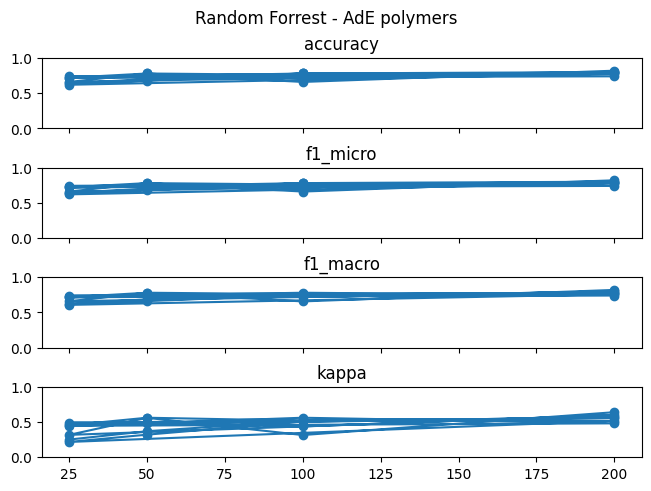

In [27]:
import matplotlib.pyplot as plt

METRICS = ['accuracy','f1_micro','f1_macro', 'kappa']
fig, ax = plt.subplots(len(METRICS), 1, sharex=True, layout = 'constrained')
ax = ax.flatten()

for i, metric in enumerate(METRICS):
    ax[i].plot(df['train_size'], df[metric], marker = 'o')
    ax[i].set_title(metric)
    ax[i].set_ylim(0,1)

fig.suptitle('Random Forrest - AdE polymers')